# Анализ рынка общественного питания Москвы

<b>Описание проекта:</b> проанализировать рынок общественного питания Москвы и презентовать полученную информацию инвесторам с целью получить инвестиции на открытие небольшого кафе<br>

**Исходные данные:** открытые данные о заведениях общественного питания в Москве 

<b>Ссылка на презентацию:</b> https://drive.google.com/file/d/1OGdfTPD6ZwvlIBK49mdmBt7PAGOqaygI/view?usp=sharing

<a id='content'></a>
# Оглавление 
[Подготовка данных](#preprocessing)
- [Импорт библиотек](#import)
- [Загрузка и проверка данных](#check)
- [Парсинг координат по адресам](#add_location)

[Анализ данных](#analysis)
- [Соотношение видов объектов общественного питания по количеству](#1)
- [Cоотношение сетевых и несетевых заведений по количеству](#2)
- [Анализ сетевых объектов общественного питания ](#3)
- [Распределение количества посадочных мест от количества ресторанов в сети](#4)
- [Среднее количество посадочных мест в различных видах объектов общественного питания](#5)
- [Расположение объектов общественного питания по улицам](#6)
- [Топ-10 улиц по количеству общественного питания](#6.1)
- [Улицы с одним объектом общественного питания](#7)
- [Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания](#8)

[Общий вывод](#9)

<a id='preprocessing'></a>
## Подготовка данных
[Назад к оглавлению](#content)

<a id='import'></a>
### Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import scipy.stats
from selenium import webdriver
import folium
from scipy import stats
from scipy.stats import shapiro
import requests 
import csv

[Назад к оглавлению](#content)

<a id='change'></a>
### Загрузка и проверка данных

#### Загрузка данных и проверка на пропущенные значения

In [2]:
# импорт открытых данных о рынке общественного питания
data = pd.read_csv('rest_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Пропущенных данных нет

In [3]:
# импорт названия районов
mos_districts = pd.read_csv('https://drive.google.com/uc?export=download&id=1nBPBIhX0rVIPpU54k__w9M_uAwlWxJkk', encoding='cp1251', sep=';')

# импорт названия улиц
mos_streets = pd.read_csv('https://drive.google.com/uc?export=download&id=1CJuks161VMytQ0R8YzU4nrMynthwymiX', encoding='cp1251', sep=';')

# объединение файлов
mos_districts.columns = mos_districts.columns.str.lower()
mos_streets.columns = mos_streets.columns.str.lower()

mos_streets = mos_streets.rename(columns={'um_te': 'kod', 'um_namef': 'street'})
mos_districts = mos_districts.rename(columns={'name': 'district'})

mos_districts_streets = mos_streets[['street', 'kod']].merge(mos_districts[['kod', 'district', 'area']], how='inner', on='kod')

mos_districts_streets.head()

,street,kod,district,area
0,1-й Ирининский переулок,102,Басманный район,Центральный административный округ
1,2-й Ирининский переулок,102,Басманный район,Центральный административный округ
2,3-й Ирининский переулок,102,Басманный район,Центральный административный округ
3,улица Казакова,102,Басманный район,Центральный административный округ
4,Казарменный переулок,102,Басманный район,Центральный административный округ


In [4]:
data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


#### Замена типа данных в столбце chain на bool

In [5]:
def type_change(item):
    if item == 'да':
        return True
    else:
        return False
    
data['chain'] = data['chain'].apply(type_change)

#### Проверка на дубликаты

In [6]:
print('Количество дубликатов в датасете: ', data.duplicated().sum())

Количество дубликатов в датасете:  0


In [7]:
# проверка на неявные дубликаты в столбце object_type
data.groupby('object_type')['object_type'].count()

object_type
бар                                   856
буфет                                 585
закусочная                            360
кафе                                 6099
кафетерий                             398
магазин (отдел кулинарии)             273
предприятие быстрого обслуживания    1923
ресторан                             2285
столовая                             2587
Name: object_type, dtype: int64

Неявных дубликатов в столбце object_type нет

In [8]:
# проверка на дубликаты в столбце id (количество уникальных значений)
data['id'].value_counts().count()

15366

Дубликатов в стоблце id нет - все значения уникальные

In [9]:
# проверка на дубликаты без id
data.duplicated(subset=['object_name', 'chain', 'object_type', 'address', 'number']).sum()

82

In [10]:
# удаление дубликатов
data.drop_duplicates(subset=['object_name', 'chain', 'object_type', 'address', 'number']).reset_index(drop=True)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,True,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15279,208537,Шоколадница,True,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15280,209264,Шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",10
15281,209186,Шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",20
15282,221900,Шоколадница,True,кафе,"город Москва, поселение Московский, Киевское ш...",36


In [11]:
# проверка сетевых заведений
data[data['chain']]['object_name'].value_counts()

KFC                     155
Шоколадница             141
Макдоналдс              122
Бургер Кинг             122
Домино'с Пицца           86
                       ... 
КАФЕ «МУ-МУ»              1
Ресторан Маки-Маки        1
Ресторан «ИЛЬ ПАТИО»      1
Кофе Хаус,Экспресс        1
Мята                      1
Name: object_name, Length: 724, dtype: int64

В столбце присутствуют неявные дубликаты. Например: ПРОНТО и Ресторан "Пронто", KFC и KFC Волгоградский

In [12]:
# Обработка неявных дубликатов в столбце object_name
clear_words = ['кафе ', 'ресторан ', '«', '»', ' волгоградский', 'кофейня ', 'ростикс ', 'закусочная ', 
               'предприятие быстрого обслуживания ', 'суши бар ', 'пиццерия ', 'сеть магазинов ', 'пбо ', 'готовые блюда ', 
              'быстрого питания ', 'предприятие ', 'лаундж-бар ', 'бар ', ' октябрьская', 'мороженного ', ' покрышкина', 
               ' бутово', 'ресторан', 'москва - ', 'кальянная ', 'кальян- ', ' шаболовка', 'японской кухни ', ' кафе',
               '. экспрессо и капучино бар', ' frozen yogurt', ' domino,s pizza', ' автозаводская', ' вавилова',
              'стейк-хаус ', 'магазин готовой еды ', 'точка продажи готовой еды ', ' братья караваевы', 'кальян-', 
               'семейное ', 'и кондитерская ', '-пекарня']

def clear_name(name):
    for item in clear_words:
        if name.find(item)!= -1:
            name = name.replace(item, '')
        elif (name == 'старбакс' or name == 'starbucks старбакс' or name == 'старбакс кофе' or name == 'starbucks кофе' 
              or name == 'starbucks coffee' or name == 'starbucks, старбакс кофе' or name == 'старбакс starbucks'):
            name = 'starbucks'
        elif name == 'сабвей':
            name = 'subway'
        elif (name == 'прайм' or name == 'prime star прайм стар' or name == 'праймстар' or name == 'prime прайм стар' 
              or name == 'prime прайм стар прайм-кафе' or name == 'праймпрайм стар' or name == 'прайм-прайм стар' or
             name == 'прайм-кафе' or name == 'прайм стар' or name == 'prime (прайм стар)'):
            name = 'prime'
        elif name == 'torro grill торро гриль':
            name = 'торро гриль'
        elif name == 'кофе-хаус':
            name = 'кофе хаус'
        elif (name == 'кофе тун' or name == 'кофетун'):
            name = 'тун'
        elif name == 'бургер кинг burger king' or name == 'burger king':
            name = 'бургер кинг'
        elif (name == 'иль патио il patio' or name == 'иль-патио'):
            name = 'иль патио'
        elif name == 'суши маки-маки':
            name = 'маки-маки'
        elif name == 'братьев караваевых':
            name = 'кулинарная лавка братьев караваевых'
    return name

data['clear_name'] = data['object_name'].str.lower().apply(clear_name)

display(data[data['chain']]['clear_name'].value_counts())

kfc                 187
шоколадница         183
макдоналдс          173
бургер кинг         158
теремок             109
                   ... 
урожай                1
гурмания              1
шварцвальд            1
джардино да пино      1
мята                  1
Name: clear_name, Length: 375, dtype: int64

<b>Вывод:</b> Данные загружены корректно. Пропущенных значений, явных и неявных дубликатов нет. Тип данных в столбце chain был изменен на bool.<br><br>
Среди сетевых заведений встречаются сети всего с одним заведением. Часть названий вбиты некорректно и, возможно, несетевые заведения ошибочно указаны как сетевые. Часть названий сестевых заведений имеют разный тип заведения

[Назад к оглавлению](#content)

<a id='add_location'></a>
## Парсинг координат по адресам

Ниже код, который позволяет спарсить координаты объекта по его адресу с google maps и сохранить полученные координаты в файл. Парсинг занимает около 4х часов 

In [13]:
# получим координаты по адресу
Url_With_Coordinates = []
mel = []

for item in data['address']:
    mel.append('https://www.google.com/maps/search/' + item)

option = webdriver.ChromeOptions()
prefs = {'profile.default_content_setting_values': {'images':2, 'javascript':2}}
option.add_experimental_option('prefs', prefs)

driver = webdriver.Chrome("C:\\chromedriver.exe", options=option)

for url in mel:
    driver.get(url)
    Url_With_Coordinates.append(driver.find_element_by_css_selector('meta[itemprop=image]').get_attribute('content'))
    
driver.close()

# сохраним в файл
with open('Url_With_coordinates.csv', 'w') as file:
    wr = csv.writer(file)
    wr.writerow(Url_With_Coordinates)

# получение координат из спарсенных значений
mos = pd.read_csv('Url_With_coordinates.csv')

In [15]:
# обработка спарсенных координат
coordinates = pd.DataFrame(data=mos.T.index, columns=['url'], copy=True)

In [16]:
# добавление широты и долготы заведения в датасет
def add_coordinates_lat(item):
    try:
        return item.split('?center=')[1].split('&zoom=')[0].split('%2C')[0]
    except:
        print('error')
        
def add_coordinates_long(item):
    try:
        return item.split('?center=')[1].split('&zoom=')[0].split('%2C')[1]
    except:
        print('error')

data['lat'] = coordinates['url'].apply(add_coordinates_lat)
data['long'] = coordinates['url'].apply(add_coordinates_long)

[Назад к оглавлению](#content)

<a id='analysis'></a>
## Анализ данных

<a id='1'></a>
### Соотношение видов объектов общественного питания по количеству

In [17]:
# количество видов объектов общественного питания
data.groupby('object_type')['object_type'].count().sort_values()

object_type
магазин (отдел кулинарии)             273
закусочная                            360
кафетерий                             398
буфет                                 585
бар                                   856
предприятие быстрого обслуживания    1923
ресторан                             2285
столовая                             2587
кафе                                 6099
Name: object_type, dtype: int64

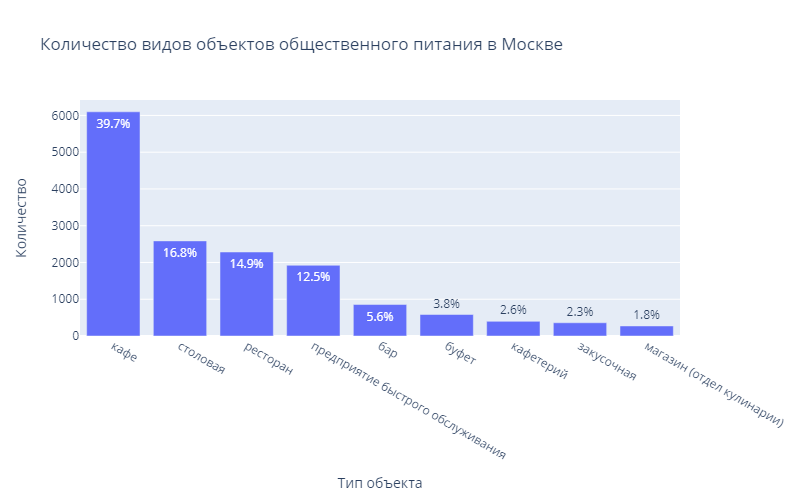

In [18]:
# построение графика
object_type_count = (data.groupby('object_type', as_index=False)
                     .agg({'object_name':'count'})
                     .sort_values(by='object_name', ascending=False)
                    )
object_type_count['percent'] = round(object_type_count['object_name'] 
                                  / data.groupby('object_type')['object_type'].count().sum() * 100, 1).astype('str') + '%'


fig = px.bar(object_type_count, x='object_type', y='object_name', 
             title="Количество видов объектов общественного питания в Москве",
             text='percent',
             labels={'object_type':'Тип объекта', 'object_name': 'Количество'}, width=800, height=500)
fig.show("png")

<b>Вывод:</b> Больше трети объектов общественного питания в Москве - кафе (39.7%). Далее идут столовые (16.8%), рестораны (14.9%) и предприятия быстрого обслуживания(12.5%). 
Меньше всего представлены кафетерии (2.6%), закусочные (2.3%) и отделы кулинарии в магазинах (1.8%).

<a id='2'></a>
### Cоотношение сетевых и несетевых заведений по количеству

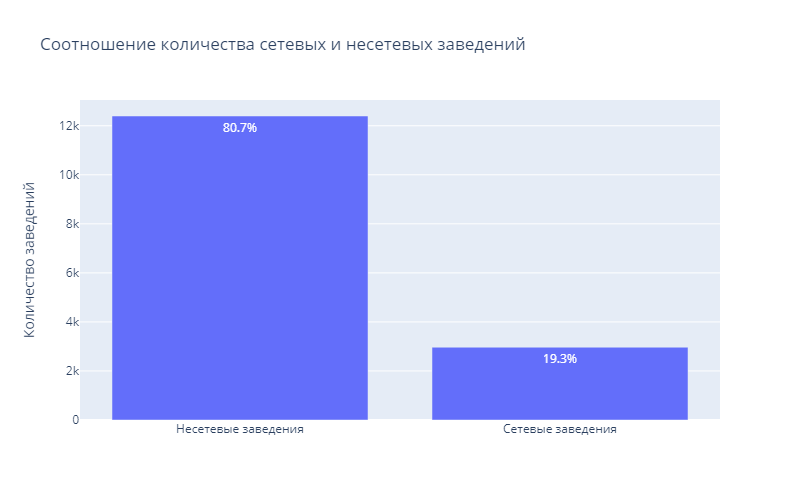

In [19]:
# построение графика
object_chain_count = data.groupby('chain', as_index=False).agg({'id': 'count'}).sort_values(by='id', ascending=False)

#fig = px.pie(object_chain_count, values='id',
#            title = 'Соотношение количества сетевых и несетевых заведений',
#            names = ['Несетевые заведения', 'Сетевые заведения'], width=600, height=600)
#fig.show()

def change_name(item):
    if item:
        return 'Сетевые заведения'
    else:
        return 'Несетевые заведения'

object_chain_count['chain'] = object_chain_count['chain'].apply(change_name)

object_chain_count['percent'] = round(object_chain_count['id'] 
                                  / data.groupby('chain')['chain'].count().sum() * 100, 1).astype('str') + '%'

fig = px.bar(object_chain_count, x='chain', y='id', 
             title='Соотношение количества сетевых и несетевых заведений',
             text='percent',
             labels={'id':'Количество заведений','chain':' '}, width=800, height=500)
fig.show("png")

<b>Вывод: </b> 19.3% заведений не сетевые, 80.7% сетевые

<a id='3'></a>
### Анализ сетевых объектов общественного питания 

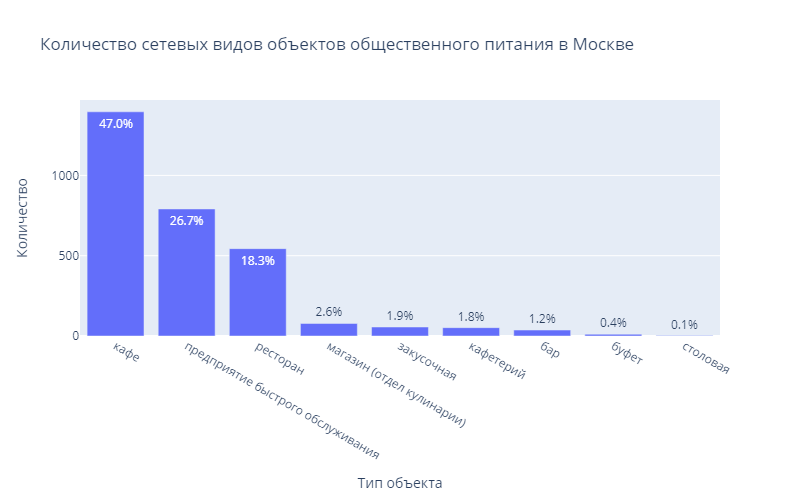

In [20]:
# построение графика
object_type_count_chain = (data[data['chain']].groupby('object_type', as_index=False)
                     .agg({'object_name':'count'})
                     .sort_values(by='object_name', ascending=False)
                    )

object_type_count_chain['percent'] = (round(object_type_count_chain['object_name'] 
                                  / data[data['chain']].groupby('object_type')['object_type'].count().sum() * 100, 1)
                                  .astype('str') + '%')

fig = px.bar(object_type_count_chain, x='object_type', y='object_name', 
             title="Количество сетевых видов объектов общественного питания в Москве",
             text='percent',
             labels={'object_type':'Тип объекта', 'object_name': 'Количество'}, width=800, height=500)
fig.show("png")

<b>Вывод: </b>почти половина (47%) сетевых заведений это кафе, далее идут преприятия быстрого обслуживания (26.7%) и рестораны (18.3%). Остальные виды объектов общественного питания занимают не более 3%

###  Доля сетевых объектов от всех объектов общественного питания по типам

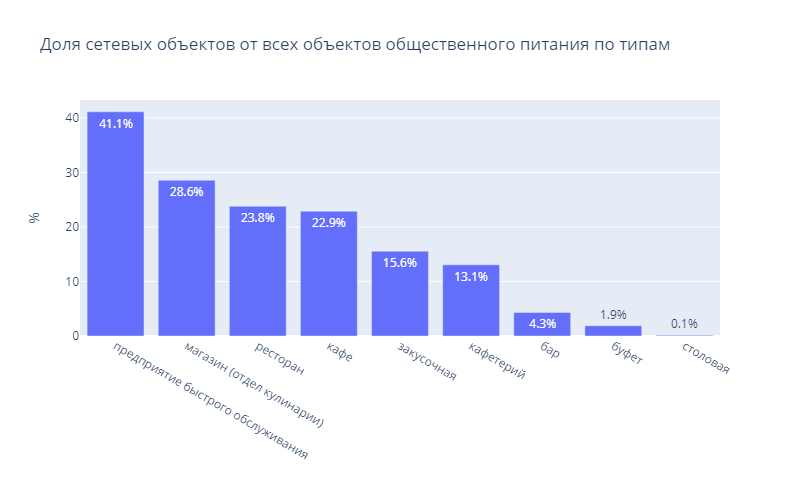

In [21]:
# построение графика
object_type_count_chain = (data[data['chain']].groupby(['object_type'], as_index=False)
                     .agg({'object_name':'count'})
                    )

object_type_count_all = (data.groupby(['object_type'], as_index=False)
                     .agg({'object_name':'count'})
                    )

object_type_relative_count_chain = object_type_count_chain.merge(object_type_count_all, on='object_type', 
                                                                 suffixes=('_chain', '_notchain'))

object_type_relative_count_chain['relative'] = (object_type_relative_count_chain['object_name_chain']
                                                /object_type_relative_count_chain['object_name_notchain'] * 100)


object_type_relative_count_chain['percent'] = (round(object_type_relative_count_chain['relative'], 1)
                                  .astype('str') + '%')

fig = px.bar(object_type_relative_count_chain.sort_values(by='relative', ascending=False), x='object_type', y='relative', 
             title="Доля сетевых объектов от всех объектов общественного питания по типам",
             text='percent',
             labels={'object_type':'', 'relative': '%'}, width=800, height=500)
fig.show("png")

In [22]:
# топ 10 сетевых заведений
data[data['chain']].groupby(['clear_name'], as_index=False).agg({'id': 'count'}).sort_values(by='id', ascending=False).head(10)

,clear_name,id
26,kfc,187
361,шоколадница,183
208,макдоналдс,173
98,бургер кинг,158
318,теремок,109
148,домино'с пицца,99
192,крошка картошка,96
218,милти,81
304,суши wok,76
43,starbucks,68


  
Cетевое распространение характерно для предприятий быстрого обслуживания (41% заведений данного типа).
Далее идут магазины (29% заведений), рестораны (24% заведений) и кафе (23% заведений).
    
Меньше всего представлены столовые.

Самые распространенные сетевые заведения - это заведения, где можно быстро покушать

<a id='4'></a>
### Распределение количества посадочных мест от количества ресторанов в сети
Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

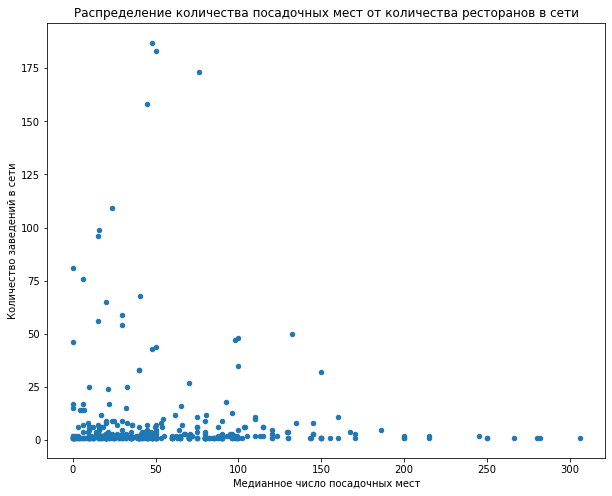

In [23]:
# построение графика
object_chain_number = (data[data['chain']].groupby('clear_name', as_index=False)
                       .agg({'id': 'count', 'number': 'median'})
                       .sort_values(by='id')
                      )
object_chain_number.columns = ['Название сети', 'Количество заведений в сети', 'Медианное число посадочных мест']
object_chain_number.plot(x='Медианное число посадочных мест', y='Количество заведений в сети', 
                         kind='scatter', figsize=(10,8), 
                         title='Распределение количества посадочных мест от количества ресторанов в сети')
plt.show()

Зависимость между количеством заведений в сети и количеством посадочных мест не просматривается. Оценим корреляцию

In [24]:
# проверка количества заведений в сети на нормальность распределения
stat, p = shapiro(object_chain_number['Количество заведений в сети'])
display(p)
stat, p = shapiro(object_chain_number['Медианное число посадочных мест'])
display(p)

# распределение не нормальное. Оценка корреляции Спирмена 
display(scipy.stats.spearmanr(object_chain_number['Количество заведений в сети'], 
                              object_chain_number['Медианное число посадочных мест'])
       )

display(np.percentile(object_chain_number['Количество заведений в сети'], [50, 90]))
display(np.percentile(object_chain_number['Медианное число посадочных мест'], [50, 90]))

8.774002906992198e-35

1.2089458685445998e-18

SpearmanrResult(correlation=-0.0336486647170302, pvalue=0.5159427384480877)

array([ 1. , 13.6])

array([ 45., 120.])

<b>Вывод: </b>зависимость между количеством посадочных мест и числом ресторанов в сети отсутсвует. В 90% сетей не больше 120 посадочных мест и 13 заведений. Медианное значение количества посадочных мест - 45. Полученный результат подтверждает, что в сетевых заведениях - мало заведений с большим количеством посадочных мест

<a id='5'></a>
### Среднее количество посадочных мест в различных видах объектов общественного питания

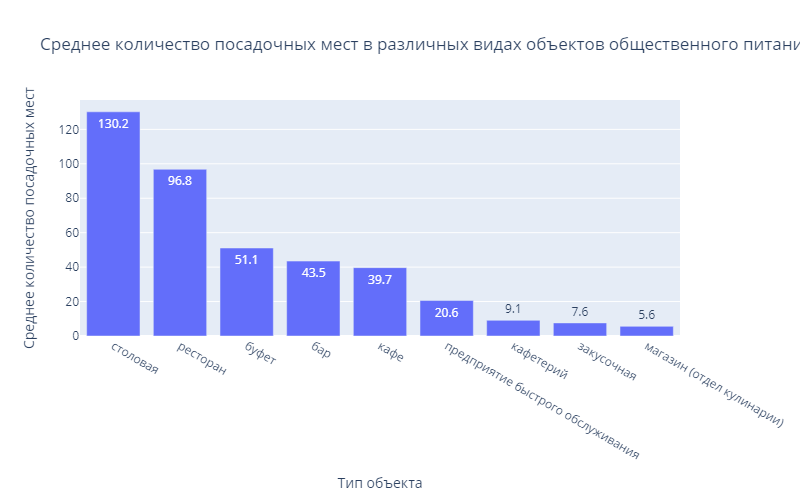

In [25]:
object_type_mean = data.groupby('object_type', as_index=False).agg({'number': 'mean'}).sort_values(by='number', ascending=False)
object_type_mean['number'] = round(object_type_mean['number'], 1)

fig = px.bar(object_type_mean, x='object_type', y='number', 
             title="Среднее количество посадочных мест в различных видах объектов общественного питания",
             text='number',
             labels={'object_type':'Тип объекта', 'number': 'Среднее количество посадочных мест'}, width=800, height=500)
fig.show("png")

<b>Вывод: </b>самое большое среднее количество посадочных мест (130.2) в столовых. Далее идут рестораны (96.8), буфеты (51.1), бары (43.5) и кафе (39.7)

<a id='6'></a>
### Расположение объектов общественного питания по улицам

In [26]:
# нанесем все заведения на карту
m = folium.Map(location=[55.7466942, 37.6237824], width=500, height=500)

def streets_all(item):
     folium.Circle(
         radius=20,
         location=[item['lat'], item['long']],
         popup=item['object_name'],
         color="crimson",
         fill=False,
     ).add_to(m)

data.apply(streets_all, axis=1)

#m
#для корректного отображения на github, вывод интерактивной карты закомментирован

0        None
1        None
2        None
3        None
4        None
         ... 
15361    None
15362    None
15363    None
15364    None
15365    None
Length: 15366, dtype: object

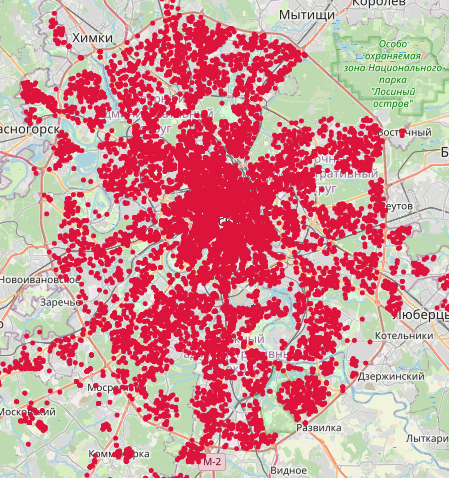

Рынок общественного питания в Москве очень развит. Максимальная плотность заведений в центре города, меньше в спальных районах

[Назад к оглавлению](#content)

<a id='6.1'></a>
### Топ-10 улиц по количеству общественного питания

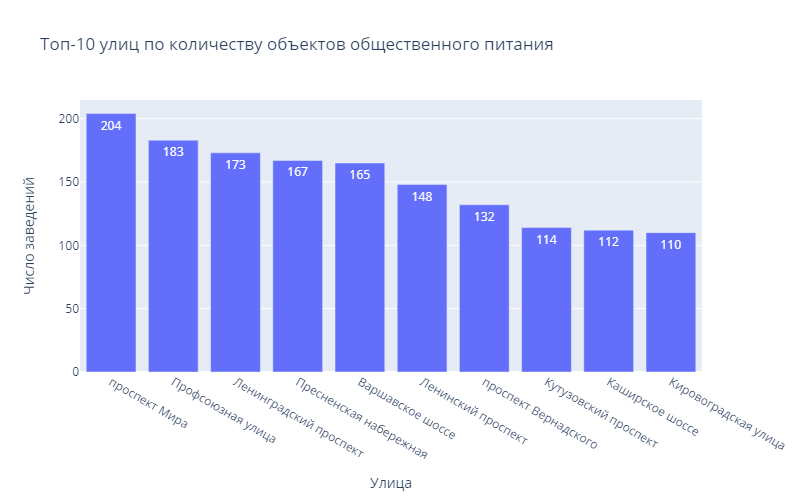

In [27]:
# график топ-10 улиц по количеству общественного питания
street_types = ['улица', 'бульвар', 'проспект', 'переулок', 'шоссе', 
'проезд', 'набережная', 'площадь', 'аллея', 'линия', 'квартал', 'мост', 'тупик', 'просека']

def street(address):
    for address_part in address.split(', '):
        for street_type in street_types:
            if address_part.lower().find(street_type)!= -1:
                return address_part

data['street'] = data['address'].apply(street)
data_with_streets = data[~(data['street'].isnull())]

object_street_count = (data_with_streets.groupby('street', as_index=False)
                       .agg({'id': 'count'})
                       .sort_values(by='id', ascending=False))

fig = px.bar(object_street_count.head(10), x='street', y='id', 
             title="Топ-10 улиц по количеству объектов общественного питания",
             text='id',
             labels={'street':'Улица', 'id': 'Число заведений'}, width=800, height=500)
fig.show("png")

In [28]:
# нанесем их на карту
m = folium.Map(location=[55.7466942, 37.6237824], width=500, height=500)
top_ten_street = object_street_count.head(10)

def street_top_ten(item):
    if (item['street'] in top_ten_street['street'].tolist()):
        folium.Circle(radius=20, 
                      location=[item['lat'], item['long']], 
                      popup=item['street'], 
                      color="crimson", 
                      fill=False,
         ).add_to(m)

data.apply(street_top_ten, axis=1)
#m
#для корректного отображения на github, вывод интерактивной карты закомментирован

0        None
1        None
2        None
3        None
4        None
         ... 
15361    None
15362    None
15363    None
15364    None
15365    None
Length: 15366, dtype: object

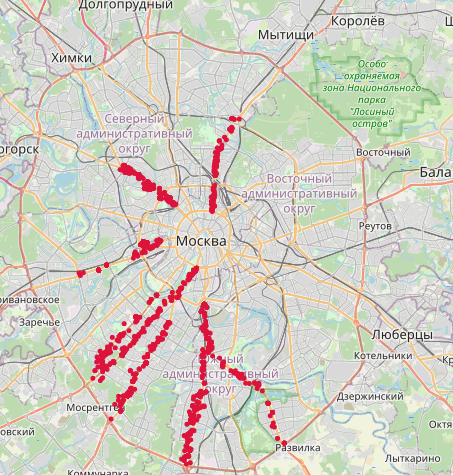

### Список районов, в которых расположены ТОП-10 улиц

In [29]:
# Список районов, в которых расположены ТОП-10 улиц
top_ten_street_district = top_ten_street.merge(mos_districts_streets[['street', 'district', 'area']], on='street')
top_ten_street_district[['street', 'district', 'area']]

,street,district,area
0,проспект Мира,район Ростокино,Северо-Восточный административный округ
1,проспект Мира,Останкинский район,Северо-Восточный административный округ
2,проспект Мира,Мещанский район,Центральный административный округ
3,проспект Мира,Алексеевский район,Северо-Восточный административный округ
4,проспект Мира,район Свиблово,Северо-Восточный административный округ
5,проспект Мира,Ярославский район,Северо-Восточный административный округ
6,проспект Мира,район Марьина Роща,Северо-Восточный административный округ
7,Профсоюзная улица,район Коньково,Юго-Западный административный округ
8,Профсоюзная улица,район Ясенево,Юго-Западный административный округ
9,Профсоюзная улица,Академический район,Юго-Западный административный округ


In [30]:
(top_ten_street_district
 .groupby('street', as_index=False)
 .agg({'district': 'nunique', 'area': 'nunique'})
 .sort_values(by='district', ascending=False))

,street,district,area
0,Варшавское шоссе,9,3
5,Ленинский проспект,8,4
9,проспект Мира,7,2
7,Профсоюзная улица,6,1
8,проспект Вернадского,5,2
1,Каширское шоссе,4,1
4,Ленинградский проспект,4,1
2,Кировоградская улица,3,1
3,Кутузовский проспект,2,1
6,Пресненская набережная,1,1


<b>Вывод: </b> улицы с самым большим количеством заведений расположены на Севере, Западе и Юге Москвы и отсутствуют на Востоке Москвы.

За исключением Пресненской набережной, улицы с самым большим количеством заведений это длинные улицы, которые начинаются в районе Садового кольца или ТТК и доходят или до спальных районов, или до границы города.

[Назад к оглавлению](#content)

<a id='7'></a>
### Улицы с одним объектом общественного питания

In [31]:
# Число улиц с одним объектом общественного питания
print('Число улиц с одним объектом общественного питания: ', object_street_count.query('id == 1').count())

# % от общего количества улиц с объектами общественного питания
print('Число улиц с одним объектом общественного питания: ',  
      round(object_street_count.query('id == 1').count() / object_street_count.count() * 100, 1), '%')

Число улиц с одним объектом общественного питания:  street    551
id        551
dtype: int64
Число улиц с одним объектом общественного питания:  street    28.9
id        28.9
dtype: float64 %


Всего улиц с 1 объектом общественного питания 551, что составляет 28.9% от всего количества улиц с объектами общественного питания

In [32]:
# нанесем их на карту
m = folium.Map(location=[55.7466942, 37.6237824], width=500, height=500)
one_street = object_street_count.query('id == 1')

def street_one(item):
    if (item['street'] in one_street['street'].tolist()):
        folium.Circle(radius=20, 
                      location=[item['lat'], item['long']], 
                      popup=item['street'], 
                      color="crimson", 
                      fill=False,
         ).add_to(m)

data.apply(street_one, axis=1)
#m
#для корректного отображения на github, вывод интерактивной карты закомментирован

0        None
1        None
2        None
3        None
4        None
         ... 
15361    None
15362    None
15363    None
15364    None
15365    None
Length: 15366, dtype: object

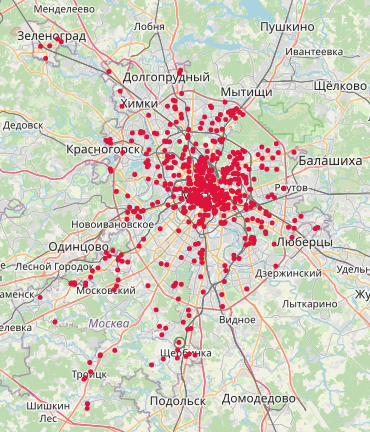

### Список районов, в которых расположены улицы с одним заведением общественного питания

In [33]:
# Список районов, в которых расположены улицы с 1 объектом общественного питания
one_street = object_street_count.query('id == 1')
one_street_district = one_street.merge(mos_districts_streets[['street', 'district', 'area']], on='street')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(one_street_district['district'].value_counts())

Таганский район               27
район Хамовники               26
Басманный район               24
Тверской район                20
Пресненский район             20
район Арбат                   18
район Марьина Роща            18
Мещанский район               16
район Замоскворечье           14
поселение Первомайское        13
район Лефортово               12
район Соколиная Гора          12
поселение Троицк              11
Даниловский район             11
район Якиманка                11
район Сокольники              11
Красносельский район          10
поселение Марушкинское        10
поселение Щербинка            10
район Богородское             10
район Южное Бутово             9
Нижегородский район            9
район Люблино                  8
район Внуково                  8
Можайский район                8
район Аэропорт                 8
район Хорошёво-Мнёвники        7
Тимирязевский район            7
Лосиноостровский район         7
район Преображенское           7
поселение 

<b>Вывод: </b> улицы с одним заведением распределены по всему городу. Больше таких улиц в центре, на севере и на востоке города. 
   
Районы, где больше всего улиц с одним заведением общественного питания - Таганский, Хамовники, Басманный, Тверской и Пресненский.


In [34]:
# округа, где больше улиц с один объектом общественного питания
one_street_district['area'].value_counts()

Центральный административный округ         186
Северо-Восточный административный округ     66
Восточный административный округ            65
Юго-Восточный административный округ        58
Северный административный округ             55
Новомосковский административный округ       46
Западный административный округ             45
Троицкий административный округ             41
Южный административный округ                29
Северо-Западный административный округ      28
Юго-Западный административный округ         28
Зеленоградский административный округ        6
Name: area, dtype: int64

Больше всего улиц с одним заведением общественного питания расположены в ЦАО (где самые короткие улицы в городе), СВАО и ВАО

[Назад к оглавлению](#content)

<a id='8'></a>
### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания (топ 10)

In [35]:
top_ten_street_list = object_street_count['street'].head(10).tolist()
data_top_ten = data.query('street in @top_ten_street_list')

# медианое количество посадочных мест по улицам топ 10
data_top_ten.groupby('street', as_index=False).agg({'number': 'median'}).sort_values(by='number')

,street,number
7,Профсоюзная улица,24.0
1,Каширское шоссе,25.0
0,Варшавское шоссе,30.0
2,Кировоградская улица,30.0
6,Пресненская набережная,30.0
3,Кутузовский проспект,40.0
4,Ленинградский проспект,40.0
8,проспект Вернадского,40.0
5,Ленинский проспект,45.0
9,проспект Мира,46.5


In [36]:
# медианное количество посадочных мест топ 10
data_top_ten['number'].median()

38.5

In [37]:
# медианное количество посадочных мест по всем улицам
data.query('street not in @top_ten_street_list')['number'].median()

40.0

In [38]:
# значима ли разница между количеством посадочных мест на топ-10 улицах и на всех улицах
alpha=0.05

results = stats.mannwhitneyu(data.query('street not in @top_ten_street_list')['number'],
                            data_top_ten['number'])
print('p-value: {}'.format(results.pvalue))

p-value: 0.113417574394208


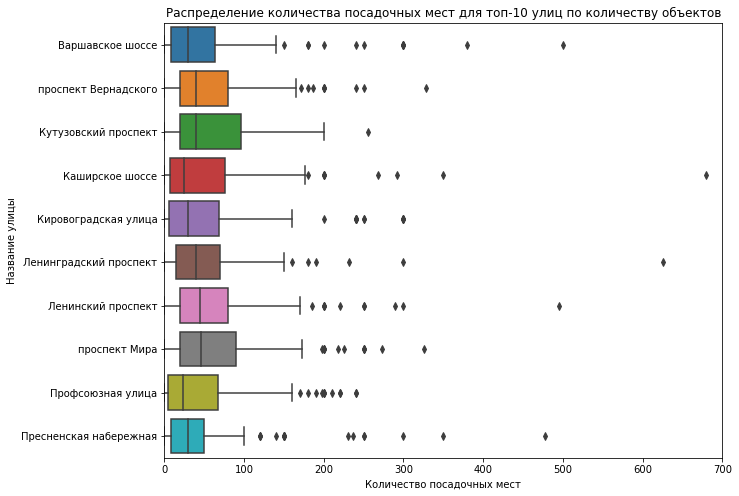

In [39]:
plt.figure(figsize=(10,8))
plt.xlim(0,700)
sns.boxplot(data=data_top_ten, x='number', y='street')
plt.title('Распределение количества посадочных мест для топ-10 улиц по количеству объектов')
plt.ylabel('Название улицы')
plt.xlabel('Количество посадочных мест')
plt.show()

<b>Вывод: </b>самое большое медианное количество посадочных мест на Ленинском проспекте (45) и Проспекте мира (46.5). Самое небольшое на Профсоюзной улице (24) и на Каширском шоссе (25)

Медианное количество посадочных мест на топ 10 улицах - 38.5

Медианное количество посадочных мест по всем улицам - 40

Статистически значимой разницы между количеством посадочных мест на топ 10 улицах и на остальных улицах нет

[Назад к оглавлению](#content)

<a id='9'></a>
### Общий вывод
<u>Общий вывод и рекомендации о виде заведения, количестве посадочных мест, а также районе расположения. Возможность развития сети.</u>


<b>Предобработка данных: </b>среди сетевых заведений встречаются сети всего с одним заведением. Часть названий вбиты некорректно и, возможно, несетевые заведения ошибочно указаны как сетевые. Часть названий сестевых заведений имеют разный тип заведения. Стоит обсудить данные феномены с коллегами, выдавшими данные с целью возможности исправления ошибок
<br><br>
<b>Типы объектов общественного питания: </b>больше трети объектов общественного питания в Москве - кафе (39.7%). Далее идут столовые (16.8%), рестораны (14.9%) и предприятия быстрого обслуживания(12.5%). Меньше всего представлены кафетерии (2.6%), закусочные (2.3%) и отделы кулинарии в магазинах (1.8%).
<br><br>
<b>Анализ сетевых заведений: </b>19.3% заведений сетевые, 80.7% не сетевые. Почти половина (47%) сетевых заведений это кафе, далее идут преприятия быстрого обслуживания (26.7%) и рестораны (18.3%). Остальные виды объектов общественного питания занимают не более 3%. Топ 10 самых распространенных сетевых заведений - это заведения, где можно быстро покушать. Зависимость между количеством посадочных мест и числом ресторанов в сети отсутсвует. В 90% сетей не больше 120 посадочных мест и 13 заведений. Медианное значение количества посадочных мест - 45
<br><br>
<b>Анализ количества посадочных мест: </b>самое большое среднее количество посадочных мест (130.2) в столовых. Далее идут рестораны (96.8), буфеты (51.1), бары (43.5)  и кафе (39.7)
<br><br>
<b>Расположение заведений и анализ топ-10 улиц с наибольшм количеством заведений: </b> улицы с самым большим количеством заведений расположены на Севере, Западе и Юге Москвы и отсутствуют на Востоке Москвы. <br><br>
Топ-10 улиц с наибольшим количеством заведений: Проспект Мира (204), Профсоюзная улица (183), Ленинградский проспект (173), Пресненская набережная (167), Варшавское шоссе (165), Ленинский проспект (148), проспект Вернадского (132), Кутузовский проспект (114), Каширское шоссе (112), Кировоградская улица (110)

За исключением Пресненской набережной, улицы с самым большим количеством заведений это длинные улицы, которые начинаются в районе Садового кольца или ТТК и доходят или до спальных районов, или до границы города.<br><br>
Самое большое медианное количество посадочных мест на Ленинском проспекте (45) и Проспекте мира (46.5). Самое небольшое на Профсоюзной улице (24) и на Каширском шоссе (25)<br><br>
Медианное количество посадочных мест на топ 10 улицах - 38.5, медианное количество посадочных мест по всем улицам - 40. Статистически значимой разницы между количеством посадочных мест на топ 10 улицах и на остальных улицах нет. <br><br>
Улицы с одним заведением распределены по всему городу, всего таких улиц 551 (28.9% от всего кол-ва улиц с объектами общественного питания в Москве). Больше таких улиц в центре, на севере и на востоке города.<br><br>
<br><br>
<b>Рекомендации: </b> Рынок общественного питания в Москве очень развит. На рынке наиболее популярны кафе, среднее количеством посадочных мест на 40 персон. Среди стевых заведений популярны заведения, где можно быстро покушать. Максимальная плотность заведений в центре города, меньше в спальных районах. 

Исходя из этого, стоит рассмотреть вариант открытия кафе на 40 персон в центре или рядом с бизнесс-центрами, с быстрой подачей блюд.

[Назад к оглавлению](#content)